In [1]:
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
path = '/nfs/team283/aa16/KR_NAS/'
os.chdir(path)
sys.path.append(path)
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import countcorrect as cc

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


Load Data:

In [2]:
adata = sc.read_h5ad('/nfs/team283/aa16/KR_NAS/data/FetalBrain_AllData_AnnData.h5ad')

In [3]:
counts_geneProbes = adata.X[:,adata.var_names != 'NegProbe-WTX']
counts_negativeProbes = np.array(adata.obsm['negProbes'])
counts_nuclei = adata.obs['nuclei'].astype(float)
names_slides = adata.obs['slide name']
print('Gene Probe Counts: \n \n', counts_geneProbes, '\n')
print('Negative Probe Counts: \n \n', counts_negativeProbes, '\n')
print('Nuclei Counts: \n \n', counts_nuclei, '\n')
print('Slide Names: \n \n', names_slides, '\n')

Gene Probe Counts: 
 
 [[  1.   1.   1. ...   5.   1.   1.]
 [  3.   7.   5. ...  10.   4.   4.]
 [  2.   1.   4. ...   8.   2.   5.]
 ...
 [ 25.  34. 106. ... 168.  81.  63.]
 [ 25.  30.  98. ... 167.  67.  64.]
 [  8.  14.  36. ...  34.  20.  24.]] 

Negative Probe Counts: 
 
 [[ 1.  3.  1. ...  0.  0. 16.]
 [ 5.  4.  7. ...  4.  5. 17.]
 [ 3.  0.  1. ...  2.  1.  3.]
 ...
 [39. 40. 61. ... 34. 51. 40.]
 [36. 37. 51. ... 50. 51. 43.]
 [10. 22.  8. ...  8. 17. 10.]] 

Nuclei Counts: 
 
 DSP-1001250001586-D-A02-0       5.0
DSP-1001250001586-D-A04-0     118.0
DSP-1001250001586-D-A05-0      10.0
DSP-1001250001586-D-A07-0     100.0
DSP-1001250001586-D-A08-0       5.0
                              ...  
273-2                        2205.0
274-2                        1727.0
275-2                        1894.0
276-2                         836.0
278-2                          35.0
Name: nuclei, Length: 480, dtype: float64 

Slide Names: 
 
 DSP-1001250001586-D-A02-0    NS_DSP_01CY
DSP-10012

Check what ROI types we have:

Remove Background with Naive Method and CountCorrect and save in AnnData object:

In [4]:
counts_geneProbes = np.asarray(adata.X)
counts_negativeProbes = np.asarray(adata.obsm['negProbes'])
# Nuclei counts can be empty for naive method:
counts_nuclei = np.array(adata.obs['nuclei'].astype(float)).reshape(len(adata.obs['nuclei']))

In [5]:
output_naive = cc.run_countcorrect(counts_geneProbes, counts_negativeProbes, counts_nuclei, naive  = True)

INFO (theano.gof.compilelock): Waiting for existing lock by process '37941' (I am process '62288')
INFO (theano.gof.compilelock): To manually release the lock, delete /nfs/users/nfs_a/aa16/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.10-64/lock_dir


Using naive model
Done.


In [6]:
adata.layers['X_corrected_naive'] = output_naive['RawCounts']
adata.layers['X_corrected_naive_cpm'] = output_naive['NormCounts']

Initializing model...
Using multi-slide model
Fitting model ...


Finished [100%]: Average Loss = 2.6378e+07


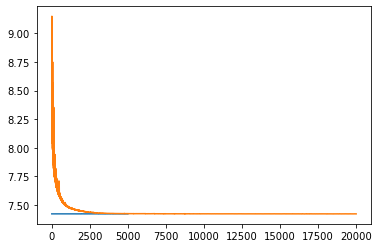

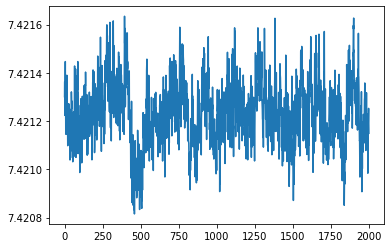

Sampling from posterior distribution...
Done.


In [7]:
output_cc = cc.run_countcorrect(counts_geneProbes, counts_negativeProbes, counts_nuclei, slide_id= names_slides,
                                naive  = False)

In [8]:
adata.layers['X_corrected_cc'] = output_cc['RawCounts']
adata.layers['X_corrected_cc_cpm'] = output_cc['NormCounts']

In [9]:
adata.write_h5ad('/nfs/team283/aa16/KR_NAS/data/FetalBrain_AllData_AnnData_1.h5ad')

In [41]:
adata = sc.read_h5ad('/nfs/team283/aa16/KR_NAS/data/FetalBrain_AllData_AnnData_1.h5ad')

In [42]:
subset = adata.obs['slide name'] == '00MU'

In [43]:
adata = adata[subset,:]

Trying to set attribute `.obs` of view, copying.


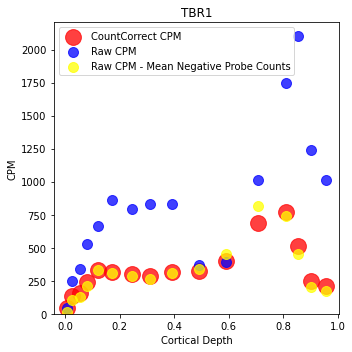

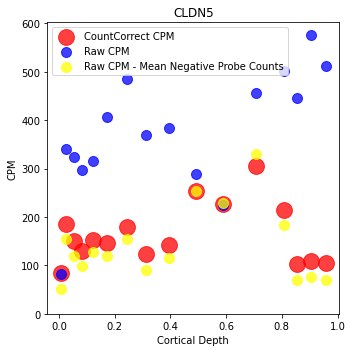

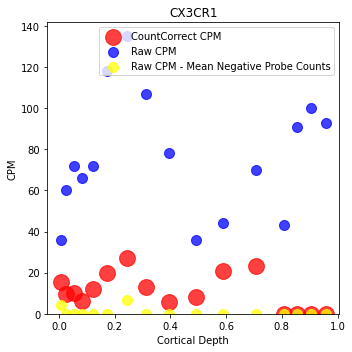

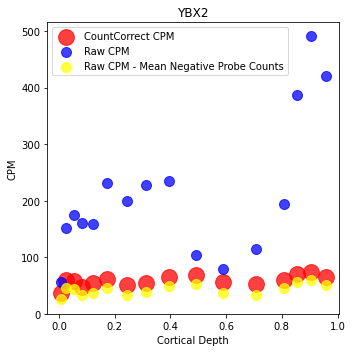

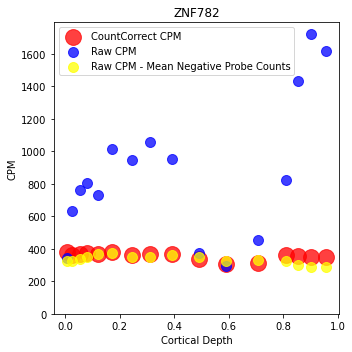

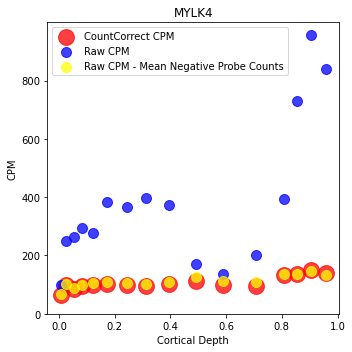

In [45]:
adata.obs['VCDepth'] = adata.obs['VCDepth'].astype(float)
x = np.asarray(adata.obs['VCDepth'])
order = np.where([adata.obs['Radial_position'][i] == '2.0' for i in range(len(adata.obs['Radial_position']))])[0]

example_genes = ['TBR1', 'CLDN5', 'CX3CR1', 'YBX2', 'ZNF782', 'MYLK4']

n_example_genes = len(example_genes)

for i in range(n_example_genes):

    fig, ax = plt.subplots(1,1, figsize=(5,5))

    ax.scatter(x[order], adata.layers['X_corrected_cc_cpm'][order,adata.var_names == example_genes[i]],
                   color = 'red', label = 'CountCorrect CPM', alpha = 0.75, s = 250)
    ax.scatter(x[order], adata.X[order,adata.var_names == example_genes[i]],
                   color = 'blue', label = 'Raw CPM', alpha = 0.75, s = 100)
    ax.scatter(x[order], adata.layers['X_corrected_naive_cpm'][order,adata.var_names == example_genes[i]],
                   color = 'yellow', label = 'Raw CPM - Mean Negative Probe Counts', alpha = 0.75, s = 100)
    ax.set_title(example_genes[i])
    ax.legend()
    ax.set_ylim(ymin = 0)
    ax.set_ylabel('CPM')
    ax.set_xlabel('Cortical Depth')
    plt.tight_layout()

#     if saveFig:
#         plt.savefig(saveFig + '_' + example_genes[i] + '.pdf')

    plt.show()